In [1]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from gp_softmax_torch_works_play_matrprev import *


%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/tensornoulli_ehr_new/data"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()


In [2]:
# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'event_for_aladynoulli.rds')))
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'prs.rds')))
# Print shapes to verify
print("Y shape:", Y.shape)
print("E shape:", E.shape)
print("G shape:", G.shape)

E = E.astype(int)

# G should be float64
G = G.astype(float)

G.shape
G = G.T
print("G shape after transposition:", G.shape)

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)
G_tensor = torch.FloatTensor(G)

# Get dimensions
N, D, T = Y_tensor.shape
P = G_tensor.shape[1]
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 10  # number of topics

# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"G: {G_tensor.shape}")  # [N, P]
print(f"Time range: 0 to {T-1}")
print(T)


Y shape: (9661, 348, 51)
E shape: (9661, 348)
G shape: (36, 9661)
G shape after transposition: (9661, 36)
Tensor shapes:
Y: torch.Size([9661, 348, 51])
E: torch.Size([9661, 348])
G: torch.Size([9661, 36])
Time range: 0 to 50
51


In [3]:
prevalence_t = compute_smoothed_prevalence(Y, window_size=5)

model2 = AladynSurvivalModel(N, D, T, K, P, G, Y, prevalence_t)
losses = model2.fit(
    event_times=E_tensor,
    num_epochs=1000,
    learning_rate=5e-4,
    convergence_threshold=1
)

/Users/sarahurbut/aladynoulli/pyScripts/gp_softmax_torch_works_play_matrprev.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 3354459.2500
Length scales: [16.9995 16.9995 16.9995 16.9995 16.9995 16.9995 16.9995 16.9995 16.9995
 16.9995]
Amplitudes: [1.0005001 1.0005001 1.0005001 1.0005001 1.0005001 1.0005001 1.0005001
 1.0005001 1.0005001 1.0005001]
Max gradients - λ: 61.5065, φ: 68.5599, γ: 448.8213
Mean condition number: 5022.34
Loss change: inf

Epoch 100
Loss: 1790354.5000
Length scales: [16.950407 16.950434 16.950418 16.950418 16.950438 16.950432 16.950438
 16.95043  16.950432 16.950418]
Amplitudes: [1.0518591 1.051857  1.0518553 1.0518587 1.0518651 1.0518553 1.0518556
 1.0518669 1.0518519 1.0518584]
Max gradients - λ: 52.1266, φ: 65.2491, γ: 32.3976
Mean condition number: 5541.51
Loss change: 9111.2500

Epoch 200
Loss: 1223378.3750
Length scales: [16.903984 16.904097 16.904009 16.904026 16.904114 16.904028 16.904114
 16.904062 16.904097 16.904026]
Amplitudes: [1.1059695 1.1059427 1.1059592 1.1059611 1.1059935 1.1059791 1.1059529
 1.1059914 1.1059275 1.1059623]
Max gradients - λ: 42.2628, 

KeyError: 'lambda_length_scales'

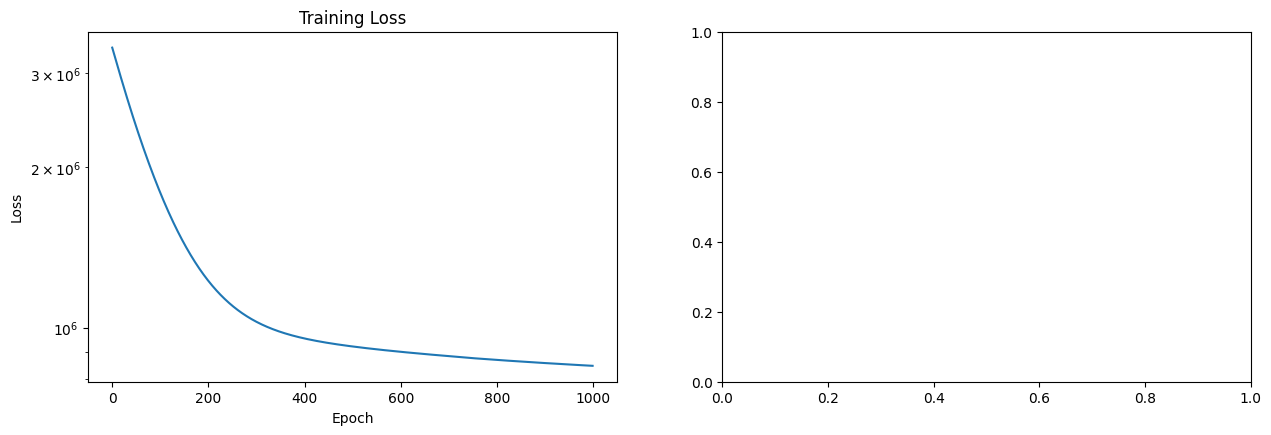

In [5]:

# Plot training diagnostics
def plot_training_diagnostics(history):
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history['loss'])
    plt.yscale('log')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Plot length scales
    plt.subplot(2, 2, 2)
    for k in range(K):
        plt.plot(np.array(history['lambda_length_scales'])[:, k], 
                label=f'λ Topic {k}')
        plt.plot(np.array(history['phi_length_scales'])[:, k], 
                '--', label=f'φ Topic {k}')
    plt.title('Length Scales')
    plt.legend()
    
    # Plot amplitudes
    plt.subplot(2, 2, 3)
    for k in range(K):
        plt.plot(np.array(history['lambda_amplitudes'])[:, k], 
                label=f'λ Topic {k}')
        plt.plot(np.array(history['phi_amplitudes'])[:, k], 
                '--', label=f'φ Topic {k}')
    plt.title('Amplitudes')
    plt.legend()
    
    # Plot condition numbers
    plt.subplot(2, 2, 4)
    plt.plot(history['condition_number_lambda'], label='λ kernels')
    plt.plot(history['condition_number_phi'], label='φ kernels')
    plt.yscale('log')
    plt.title('Condition Numbers')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot diagnostics
plot_training_diagnostics(losses)

# Get predictions
with torch.no_grad():
    pi_pred, theta_pred, phi_pred = model.forward()
    pi_pred = pi_pred.numpy()

# Plot some random predictions
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    n = np.random.randint(0, N)
    d = np.random.randint(0, D)
    plt.plot(pi_pred[n, d], label='Predicted')
    plt.plot(Y[n, d], 'r.', label='Observed')
    plt.title(f'Individual {n}, Disease {d}')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Save the model with complete history
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = "/Users/sarahurbut/Dropbox (Personal)/saved_models"
model_path = os.path.join(save_dir, f"aladyn_model_full_{timestamp}.pt")

# Get current predictions
pi_pred, theta_pred, phi_pred = model.forward()

# Save everything
torch.save({
    # Model state and training history
    'model_state_dict': model.state_dict(),
    'training_history': history,  # Save the complete training history
    
    # Model parameters
    'lambda': model.lambda_.detach(),
    'phi': model.phi.detach(),
    'gamma': model.gamma.detach(),
    'length_scales': model.length_scales.detach(),
    'log_amplitudes': model.log_amplitudes.detach(),
    
    # Predictions
    'pi_pred': pi_pred.detach(),
    'theta_pred': theta_pred.detach(),
    'phi_pred': phi_pred.detach(),
    
    # Input data
    'Y': Y,
    'G': G,
    'E': E_tensor,
    'prevalence': prevalence_t,
    
    # Hyperparameters
    'hyperparameters': {
        'N': N,
        'D': D,
        'T': T,
        'K': K,
        'P': P,
    }
}, model_path)

print(f"Model saved to: {model_path}")

# Visualize training progress
plot_training_diagnostics(history)